This notebook looks at the random effects multinomial logistic regression. The simpleset case is just one grouping variable and three levels (2 levels would just be a binary logistic regression). The model is:

TODO: add priors and such
$$
\log \left( \frac{p_{ij}}{p_{i1}} \right) = \beta_j + u_{ij}  
$$

where $p_{ij}$ is the probability of the $j$ th outcome for the $i$ th group and $u_{ij}$ is the random effect for the $i$ th group.

The random effects are assumed to be normally distributed with mean 0 and covariance matrix $\Sigma_u$

In [30]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.special import softmax

np.random.seed(33)

# Settings
num_groups = 100
num_categories = 3  # categories: 0 (pivot), 1, 2 minimal non-trivial 
 
# mean effect is zero, but we could set it to something else
mean_effect = np.zeros(num_categories - 1)

# Define covariance matrix with correlations between categories
cov_effect = np.array([
    [1.0, 0.5],
    [0.5, 2.0]
])

group_effects = multivariate_normal.rvs(mean=mean_effect, cov=cov_effect, size=num_groups)
# Add pivot logits = 0
group_effects = np.hstack([np.zeros((num_groups, 1)), group_effects])

# Store group random effects in a DataFrame
group_ids = [f'group_{i}' for i in range(num_groups)]
group_effects_df = pd.DataFrame(group_effects, columns=[f'logit_{i}' for i in range(num_categories)])
group_effects_df['group'] = group_ids

# Generate observations per group
data = []
for idx, group in enumerate(group_ids):
    n_obs = np.random.poisson(30)  #  average 30 observations per group
    
  
    logits = group_effects[idx]
    probs = softmax(logits)
    for obs in range(n_obs):
          
        observed_cat = np.random.choice(num_categories, p=probs)
        
        # Append observation
        data.append({
            'group': group,
            'group_id' : idx,
            'cat': f'cat_{observed_cat}',
            'cat_id': observed_cat,
        })

# Convert to DataFrame
simulated_df = pd.DataFrame(data)


print(simulated_df.head(10))


     group  group_id    cat  cat_id
0  group_0         0  cat_0       0
1  group_0         0  cat_2       2
2  group_0         0  cat_0       0
3  group_0         0  cat_0       0
4  group_0         0  cat_2       2
5  group_0         0  cat_2       2
6  group_0         0  cat_2       2
7  group_0         0  cat_0       0
8  group_0         0  cat_0       0
9  group_0         0  cat_2       2


Check empirical covariance of logits

In [29]:
 
emp_cov = np.cov(group_effects[:,1:].T)
print(emp_cov)


[[1.01255788 0.50686814]
 [0.50686814 2.28913477]]


We can try to use bambi here, but it doesn't support correlated random effects in this case. In BRMS we can do it with `(1|ID|group)` syntax. I dont believe bambi has a simular feature. Best we can do is to estimate uncorrelated effects.

In [7]:
import bambi as bmb

model = bmb.Model('cat ~  (1| group)', data=simulated_df, family='categorical')
results = model.fit()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|group_sigma, 1|group_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [8]:
import arviz as az
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[cat_1],-0.375,0.159,-0.679,-0.086,0.003,0.002,2470.0,2894.0,1.00
Intercept[cat_2],-0.193,0.161,-0.505,0.095,0.003,0.002,2443.0,2689.0,1.00
1|group_sigma,1.277,0.116,1.071,1.502,0.003,0.002,1422.0,2424.0,1.00
"1|group[cat_1, group_0]",-1.456,0.886,-3.290,0.056,0.011,0.016,7072.0,3153.0,1.00
"1|group[cat_1, group_1]",0.192,0.786,-1.253,1.674,0.009,0.013,7236.0,3142.0,1.00
...,...,...,...,...,...,...,...,...,...
"1|group[cat_2, group_95]",-0.990,0.803,-2.531,0.467,0.010,0.015,6544.0,2807.0,1.00
"1|group[cat_2, group_96]",-1.828,0.871,-3.427,-0.129,0.011,0.017,7018.0,2733.0,1.00
"1|group[cat_2, group_97]",-1.011,0.651,-2.185,0.266,0.008,0.011,6790.0,2946.0,1.01
"1|group[cat_2, group_98]",1.765,0.947,0.065,3.553,0.012,0.018,6988.0,2845.0,1.00


The model we really want looks like this:

In [9]:
num_groups

100

In [31]:
import pymc as pm
import pytensor.tensor as pt

num_obs = simulated_df.shape[0]

with pm.Model() as model:
     
    group_idx = pm.Data("group_idx", simulated_df["group_id"].values)
    cat_obs = pm.Data("cat_obs", simulated_df["cat_id"].values)
    sd_dist = pm.HalfStudentT.dist(nu=3, sigma=10)
    
    chol_corr,_, _ = pm.LKJCholeskyCov(
        "chol_corr",
        n=num_categories - 1,
        eta=1,
         sd_dist=sd_dist
    )

    z = pm.Normal(
        "z",
        0, 1,
        shape=(num_groups, num_categories - 1)
    )

    group_effects_m = pm.Deterministic(
        "group_effects",
        pt.dot(z, chol_corr.T), 
    )

    mean_effect = pm.Normal(
        "mean_effect",
        0, 1,
        shape=(num_categories - 1)
    )


    group_eff_obs = group_effects_m[group_idx, :]  # (num_obs, num_categories - 1)

    logits = pt.concatenate(
        [pt.zeros((num_obs, 1)), group_eff_obs + mean_effect],
        axis=1
    ) 

    
    pm.Categorical("obs", logit_p=logits, observed=cat_obs)

    trace = pm.sample()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_corr, z, mean_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [32]:
az.summary(trace, var_names = ["~z","~group_effects"])

/Users/ronaldlegere/miniconda3/envs/multinom/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/ronaldlegere/miniconda3/envs/multinom/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean_effect[0],-0.128,0.128,-0.373,0.106,0.005,0.002,640.0,1011.0,1.00
mean_effect[1],-0.236,0.167,-0.534,0.099,0.007,0.004,621.0,852.0,1.00
chol_corr[0],1.139,0.111,0.942,1.349,0.003,0.002,1265.0,2248.0,1.00
chol_corr[1],0.549,0.206,0.145,0.912,0.012,0.005,294.0,911.0,1.02
chol_corr[2],1.500,0.134,1.244,1.740,0.004,0.002,989.0,1768.0,1.00
"chol_corr_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,NaN,4000.0,4000.0,NaN
"chol_corr_corr[0, 1]",0.338,0.115,0.121,0.545,0.006,0.002,352.0,1088.0,1.02
"chol_corr_corr[1, 0]",0.338,0.115,0.121,0.545,0.006,0.002,352.0,1088.0,1.02
"chol_corr_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,3954.0,3588.0,1.00
chol_corr_stds[0],1.139,0.111,0.942,1.349,0.003,0.002,1265.0,2248.0,1.00


In [42]:
import arviz as az

In [33]:
dat = az.extract(trace, group = 'posterior', var_names = ["chol_corr_corr","chol_corr_stds"], combined = True)
corr = dat["chol_corr_corr"].values
stds = dat["chol_corr_stds"].values[:,None,:]

In [34]:
covariances = corr * stds * stds.transpose(1, 0, 2) 

In [39]:
stds.shape

(2, 1, 4000)

In [ ]:
covariances =  corr * stds * stds.transpose(1, 0, 2) 

In [35]:
mean_covariance = np.mean(covariances, axis=2)

print(mean_covariance)

[[1.30903602 0.63027184]
 [0.63027184 2.61169674]]


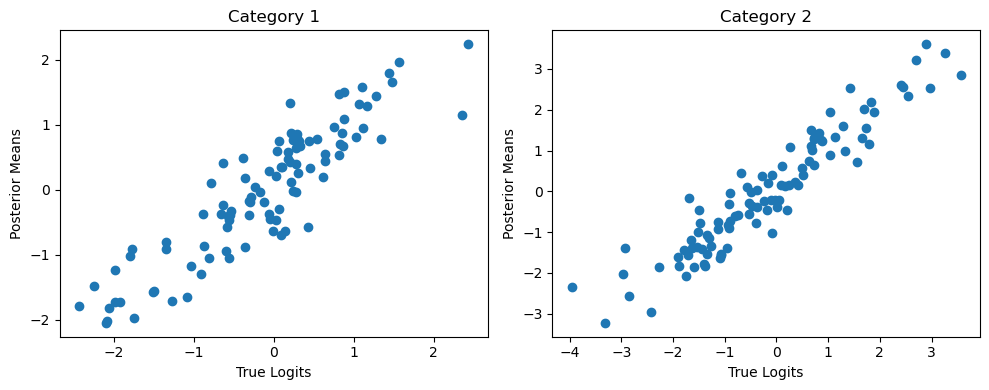

In [36]:
 
true_effects = group_effects[:, 1:]  # exclude baseline logits

 
posterior_means = trace.posterior["group_effects"].mean(dim=["chain", "draw"]).values

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):
    axes[i].scatter(true_effects[:, i], posterior_means[:, i])
    axes[i].set_xlabel("True Logits")
    axes[i].set_ylabel("Posterior Means")
    axes[i].set_title(f"Category {i+1}")

plt.tight_layout()
plt.show()
